In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint, ode, solve_ivp
from sympy.solvers import solve
from scipy import interpolate
import sympy 
from scipy.linalg import eig
from scipy.optimize import root_scalar



# Problem 1

$$\frac{d}{dy}\left(\mu(y)\frac{du}{dy}\right) = \frac{\partial p}{\partial x}$$

$$\frac{d\mu(y)}{dy}u' + \mu(y)u'' = \frac{\partial p}{\partial x} \Leftrightarrow \frac{-\mu_0\cdot \frac{\alpha}{H}}{(1+\alpha \frac{y}{H})^2}u' + \frac{\mu_0}{(1+\alpha \frac{y}{H})}u'' = \frac{\partial p}{\partial x}$$


$$ u_1 = u, u_2 = u' \Rightarrow $$

\begin{equation}
\begin{cases}
u_1 ' = u_2,
\\u_2' = \frac{\frac{\alpha}{H}}{1+\alpha \frac{y}{H}}u_2 + \frac{\partial p}{\partial x}{\frac{1+\alpha\frac{y}{H}}{\mu_0}},
\\ u|_{y=0} = 0,
\\ u|_{y = H} = U
\end{cases}
\end{equation}

Direct Method: 
$$A_i = \frac{-\frac{\alpha}{H}}{1+\alpha \frac{y_i}{H}}, B_i = 0, f_i = \frac{\partial p}{\partial x}\frac{1+\alpha \frac{y_i}{H}}{\mu_0}$$

$$ \alpha_i = \left(\frac{1}{h^2} + \frac{A_i}{2h}\right),
\beta_i = (B_i - 2/h^2), 
\gamma_i = \left(1/h^2 - A_i/2h\right)$$

In [2]:
def analytic_solution(x,a):
    return -(x *(a**2 *(-1 + x) *x + 3 *(1 + x) + a*(-2 + 3*x + 2*x**2)))/(3 *(2 + a))

In [3]:
def plot_solution(solution, grid,density, alpha,name,ax):
    step = int(1/density)
    zero = [0 for i in range(len(grid[::step]))]
    ax.quiver(zero, grid[::step], solution[::step],zero,color='#A23BEC',scale_units='x', scale=1,headwidth = 1,headlength = 3)
    #ax.plot(grid[::step], solution[::step],color='#A23BEC')
    ax.set_xlim([solution.min()-0.5,solution.max()+0.5])
    ax.set_title(fr'{name} solution for $\alpha$ = {alpha}')

In [4]:

def direct_method(N,H,ax,press_grad = -1, u = -1, mu_0 = 1, alpha = -0.5,plot = True, density = 0.5):
    # viscosity = lambda y: mu_0/(1+alpha/H * y)
    grid = np.linspace(0,H,num=N+1, endpoint=True)
    points_for_matrix = grid[1:-1]
    h = grid[1] - grid[0]
    A = -alpha/H / (1+alpha/H * points_for_matrix)
    f = press_grad/mu_0 * (1+alpha/H * points_for_matrix)
    rhs = f
    rhs[0] = f[0] - (1/h**2 - A[0]/(2*h))*0
    rhs[-1] = f[-1] - (1/h**2 + A[-1]/(2*h))*u

    matrix = np.zeros([len(rhs),len(rhs)])
    matrix[0][0] = -2/h**2
    matrix[0][1] = (1/h**2 + A[0]/(2*h))
    matrix[-1][-2] = (1/h**2 - A[-1]/(2*h))
    matrix[-1][-1] = -2/h**2
    for i in range(1,len(rhs)-1):
            matrix[i][i-1] = (1/h**2 - A[i]/(2*h))
            matrix[i][i] = -2/h**2
            matrix[i][i+1] = (1/h**2 + A[i]/(2*h))
    y = np.linalg.solve(matrix, rhs)
    answer = np.insert(y, 0,0)
    velocity = np.append(answer, u)
    if plot:
        anal_sol = analytic_solution(grid, alpha)
        plot_solution(velocity,grid,density,alpha,'Direct Method',ax[1])

        ax[3].plot(grid, np.abs(anal_sol - velocity))
        ax[3].set_title("Error Direct Method")
        plt.draw()
        plt.show()
    return velocity,grid





In [5]:
def update_guess(previous_guess, function, value, derivative):
    return previous_guess - (function[-1]-value)/derivative[-1]

In [6]:
def odes(y,x,alpha,H,mu_0,press):
    relation = alpha/H
    # Create function of right part:
    return [x[1], relation * x[1]/(1+relation*y) + press*(1+relation*y)/mu_0]

In [7]:
def newtone(y,x,alpha,H):
    relation = alpha/H
    return [x[1], x[1]*relation/(1+relation*y)]

In [8]:
def shooting(H,ax, press_grad = -1, u = -1, mu_0 = 1, alpha = -0.5,tolerance = 1e-5,plot = True,density = 1,N = 100):
                
    guess = 1
    # Create first and last points of integration
    y_start = 0
    y_end = H
    # Initial conditions
    y_0 = 0
    grid_solution = N
    y = np.linspace(y_start,y_end,grid_solution)
    iteration = 0
    
    while(True):
        
        # Integrate using solve_ivp
        solution1 = solve_ivp(odes, (y_start, y_end),[y_0, guess],t_eval = y,method='RK45',dense_output=True,args=(alpha, H, mu_0, press_grad),rtol = tolerance, atol = tolerance/100)
        if abs(solution1.y[0][-1] - u)<tolerance:
            if plot:
                anal_sol = analytic_solution(y, alpha)
                plot_solution(solution1.y[0], solution1.t, density, alpha, 'Shooting method', ax[0])

                ax[2].plot(solution1.t, np.abs(anal_sol - solution1.y[0]))
                ax[2].set_title("Error Shooting method")
            return solution1,y
        
        new_0 = 0
        new_1 = 1
        solution_newtone = solve_ivp(newtone, (y_start, y_end),[new_0, new_1],t_eval = y,method='RK45',dense_output=True,args=(alpha, H),rtol = tolerance, atol = tolerance/100)

        #return solution1, solution_newtone
        guess2 = update_guess(guess, solution1.y[0], u, solution_newtone.y[0])
        solution2 = solve_ivp(odes, (y_start, y_end),[y_0, guess2],t_eval = y,method='RK45',dense_output=True,args=(alpha, H, mu_0, press_grad),rtol = tolerance, atol = tolerance/100)
        if abs(guess-guess2)<tolerance:
            if plot:
                anal_sol = analytic_solution(y, alpha)
                plot_solution(solution2.y[0], solution2.t, density, alpha, 'Shooting method', ax[0])

                ax[2].plot(solution2.t, np.abs(anal_sol - solution2.y[0]))
                ax[2].set_title("Error Shooting method")

            return solution2,y
        guess = guess2
    

    



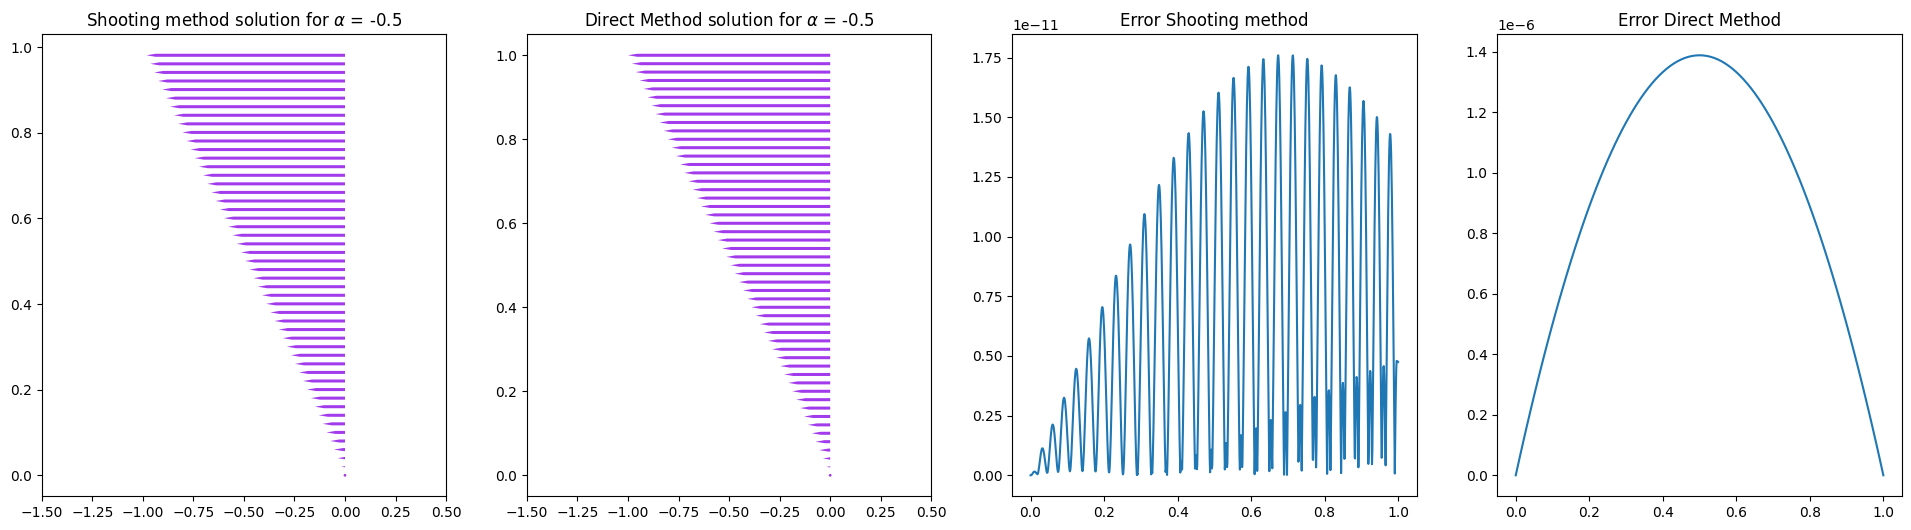

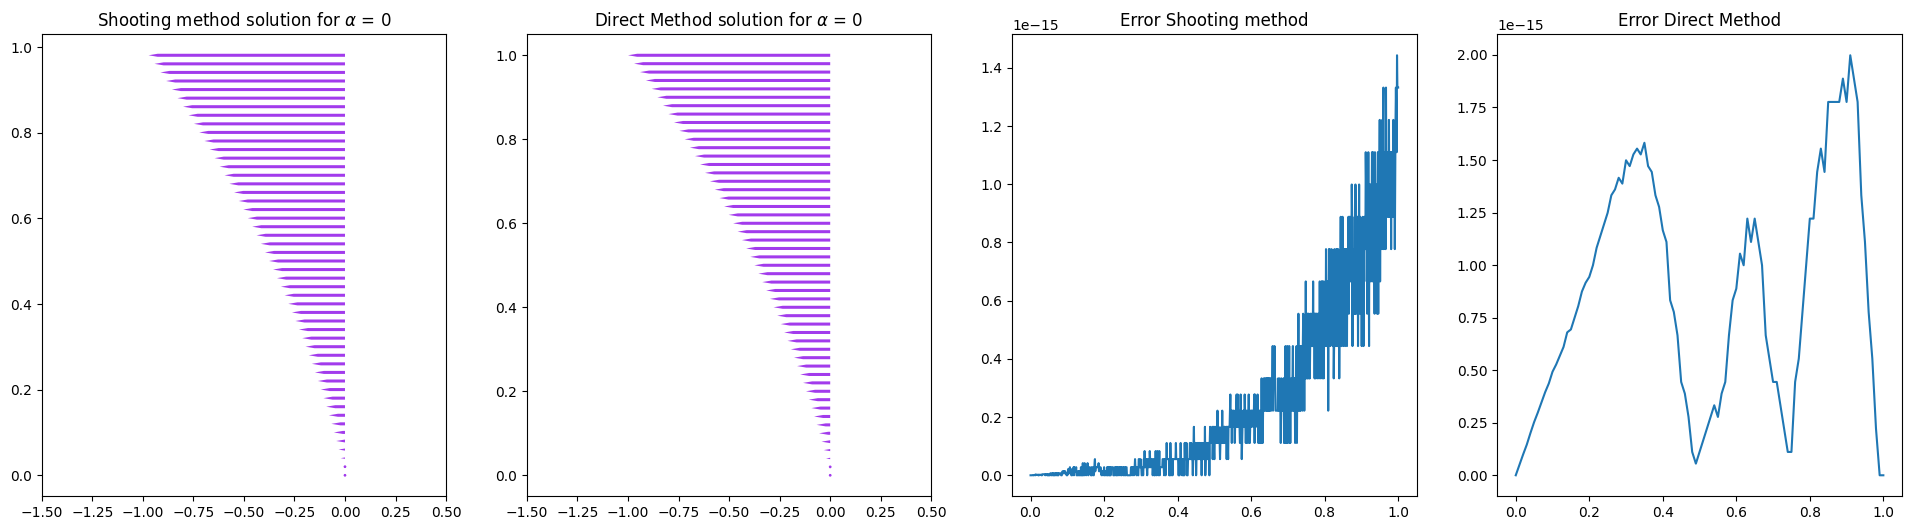

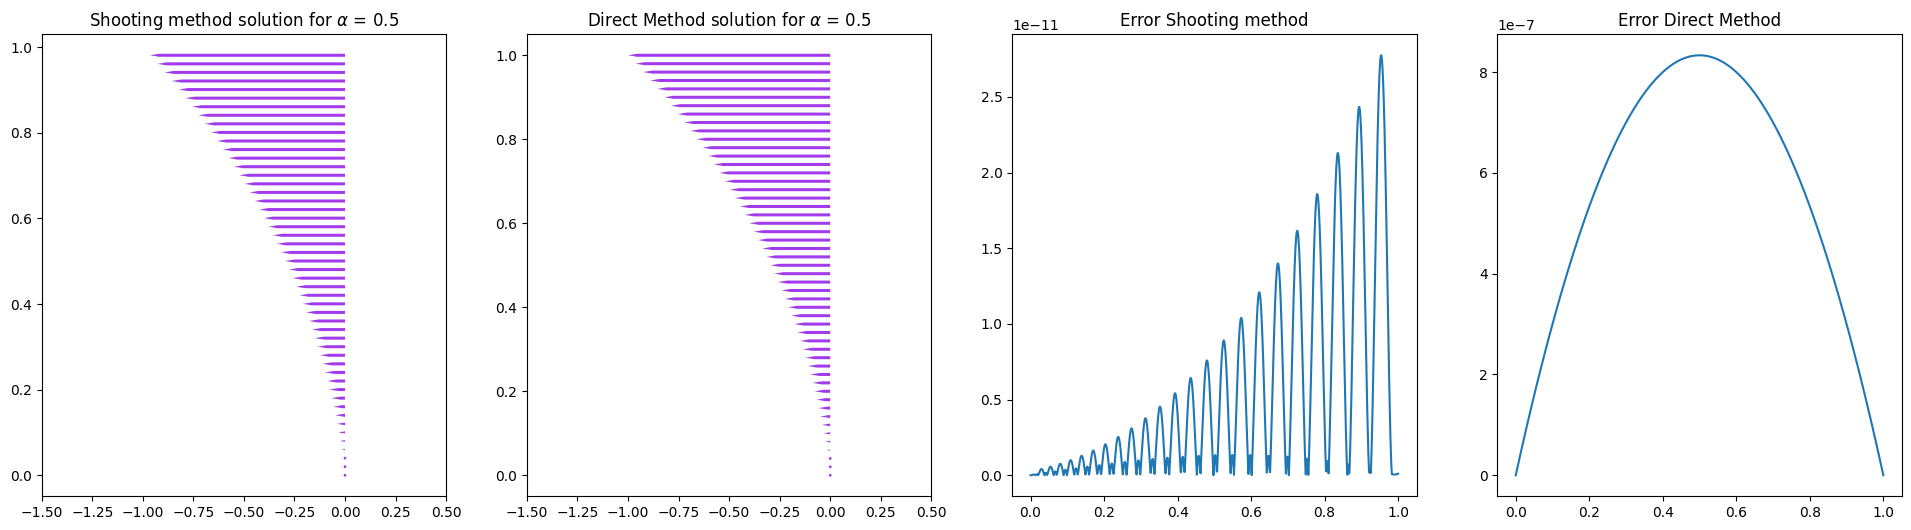

In [9]:
for alpha in [-.5,0,.5]:
    fig, ax = plt.subplots(1, 4,figsize = (24,6))  # Ensure ax is an array
    #velocity_real,grid = direct_method(1000000, 1,alpha=alpha,density=0.5,plot=False)
    velocity_shoot,grid = shooting(1,ax = ax, alpha=alpha,tolerance=1e-10, density=0.05,N = 1000)
    velocity_direct, grid = direct_method(100, 1,ax = ax,alpha=alpha,density=0.5)
    
    #print(f'For alpha = {alpha} the max difference between direct method and shooting method is {np.max(abs(velocity_direct-velocity_shoot.y[0]))}')

# Problem 2

$$f''' + \frac{1}{2}ff'' = 0$$
Boundary conditons: 
$$f(0) = f'(0) = 0, \ f'(+\infty) = 1$$

Let $u_1 = f, \ u_2 = f', \ u_3 = f''$. Then equation transforms to: 

\begin{equation}
\begin{cases}
u_1' = u_2,
\\u_2' = u_3,
\\u_3' = -\frac{1}{2}u_1\cdot u_3,
\\u_1(0) = 0,
\\u_2(0) = 0,
\\u_2(+\infty) = 1. 
\end{cases}
\end{equation}

Initial value: 0.33205733448266983 for x_max = 10


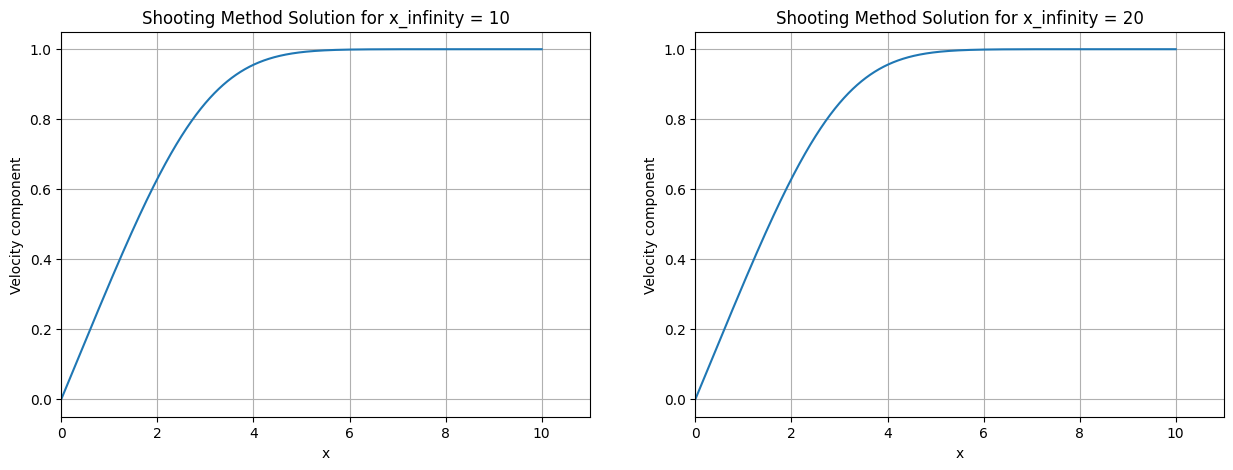

In [10]:
# Set a sufficiently large x_max to approximate "infinity"
x_max = 10
# Define the system of first-order ODEs
def odes(x, y):
    # y[0] = u1, y[1] = u2, y[2] = u3
    return [y[1], y[2], -0.5 * y[0] * y[2]]

# Define the shooting function
def shoot(guess):
    sol = solve_ivp(odes, [0, x_max], [0, 0, guess], method='RK45', dense_output=True,rtol = 1e-9, atol = 1e-10)
    
    u1, u2, u3 = sol.sol(x_max)  # Extract components at x_max
    return u2 - 1 # We want u2(x_max) to be close to 1


result = root_scalar(shoot, bracket=[0,2], method='bisect', xtol=1e-8)
x_eval = np.linspace(0, x_max, 100000)
if result.converged:
    initial_value = result.root
    print(f"Initial value: {initial_value} for x_max = {x_max}")

    solutions = []
    check = [x_max,x_max*2]
    fig,ax = plt.subplots(1,len(check),figsize = (15,5))
    for i,x_infinity in enumerate(check):
            
            sol = solve_ivp(odes, [0, x_infinity], [0, 0, initial_value],method='BDF', t_eval=x_eval,dense_output=True,rtol = 1e-9, atol = 1e-10)
            solutions.append(sol.y[1])
            # Plot the results
            #plt.plot(sol.t, sol.y[0], label="$u_1(x)$")
            ax[i].plot(sol.t, sol.y[1], label="$u_2(x)$")
            #plt.plot(sol.t, sol.y[2], label="$u_3(x)$")
            ax[i].set_xlabel('x')
            ax[i].set_xlim([0,x_max+1])
            #ax[i].set_ylim([0,1])
            ax[i].set_ylabel('Velocity component')
            ax[i].set_title(f"Shooting Method Solution for x_infinity = {x_infinity}")
            #ax[i].legend()
            ax[i].grid(True)
    
else:
    print("The shooting method did not converge.")


In [11]:
diff = np.mean(np.abs(solutions[0]-solutions[1]))
print(f'The difference between x_max = 10 and x_max = 20 is {diff}')

The difference between x_max = 10 and x_max = 20 is 4.75720574044658e-16


# Problem 3

$$y''(x) = \frac{4x^2}{(1+x)^2}y(x), \ y(1) = 3, \ y(+\infty) = 0, x\in[1,+\infty). $$

В пункте а можно запустить свой алгоритм из задачи 1, и посчитать разные значения

В пункте b, нужно найти матрицу преобразования, здесь она простая: 
\begin{equation}
\begin{cases}
y_1' = y_2
\\y_2' = \frac{4x^2}{(1+x)^2}y_1(x)
\\y_1(1) = 3
\\y_1(+\infty) = 0
\end{cases}
\end{equation}

\begin{equation}
\begin{gathered}
A_x = \begin{pmatrix}
0 & 1\\
\frac{4x^2}{(1+x)^2} & 0
\end{pmatrix}
\Rightarrow A_{\infty} = \begin{pmatrix}
0 & 1\\
4 & 0 \end{pmatrix} \Rightarrow
\\
\Rightarrow \lambda_1 = 2, \lambda_2 = -2
\\
\Rightarrow (\alpha \ \beta) \begin{pmatrix}
-2 & 1\\
4 & -2 \end{pmatrix} = (0 \ 0) \Rightarrow
e_1^T = (2 \ 1) \Rightarrow
\\ \Rightarrow 
(2 \ 1) \begin{pmatrix}
y_1(4)\\
y_2(4) \end{pmatrix} = 2y_1(4) + y_2(4) = 0\Rightarrow
\\
\begin{cases}
y_1' = y_2
\\y_2' = \frac{4x^2}{(1+x)^2}y_1(x)
\\y_1(3) = 3
\\2y_1(4) + y_2(4) = 2y(4) + y'(4) = 0
\end{cases}
\end{gathered}
\end{equation}
$$f_i' = \frac{3f_i-4f_{i-1}+f_{i-2}}{2h}$$

In [12]:
def direct_method2(h = .1,y_1 = 3,y_4 = 0,accurate = True):
    # viscosity = lambda y: mu_0/(1+alpha/H * y)
    N = int(3/h) +1
    grid = np.linspace(1,4,num=N, endpoint=True)
    #points_for_matrix = grid[1:-1]

    B = -4*np.square(grid)/np.square(1+grid)
    rhs = np.zeros((len(grid),1))
    rhs[0] = y_1
    rhs[-1] = y_4
    
    

    matrix = np.zeros([len(grid),len(grid)])
    matrix[0][0] = 1
    matrix[-1][-1] = 1
    if accurate:
        #i have found my own approximation to get accuracy O(h^2), not usual O(h). 
        rhs[-1] = 0
        matrix[-1][-1] = 2+3/(2*h)
        matrix[-1][-2] = -2/h
        matrix[-1][-3] = 1/(2*h)
    for i in range(1,len(grid)-1):
            matrix[i][i-1] = 1/h**2
            matrix[i][i] = B[i]-2/h**2
            matrix[i][i+1] = 1/h**2 
    y = np.linalg.solve(matrix, rhs).flatten()
    return y,grid





Difference between modified and not modified BC = 0.00786516848496434 for h = 0.1
Difference between modified and not modified BC = 0.007710388941699015 for h = 0.05
Difference between modified and not modified BC = 0.007629932062910776 for h = 0.025


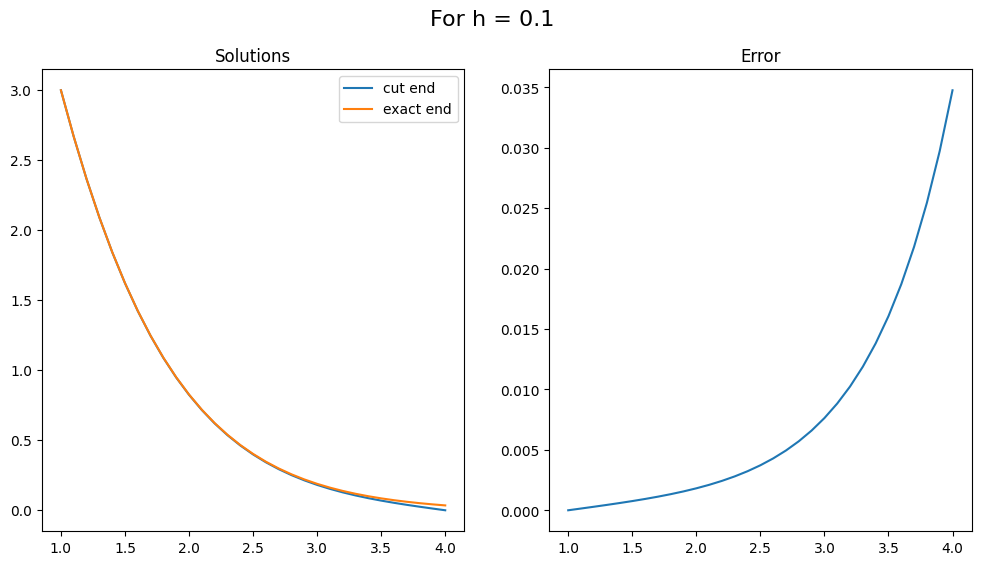

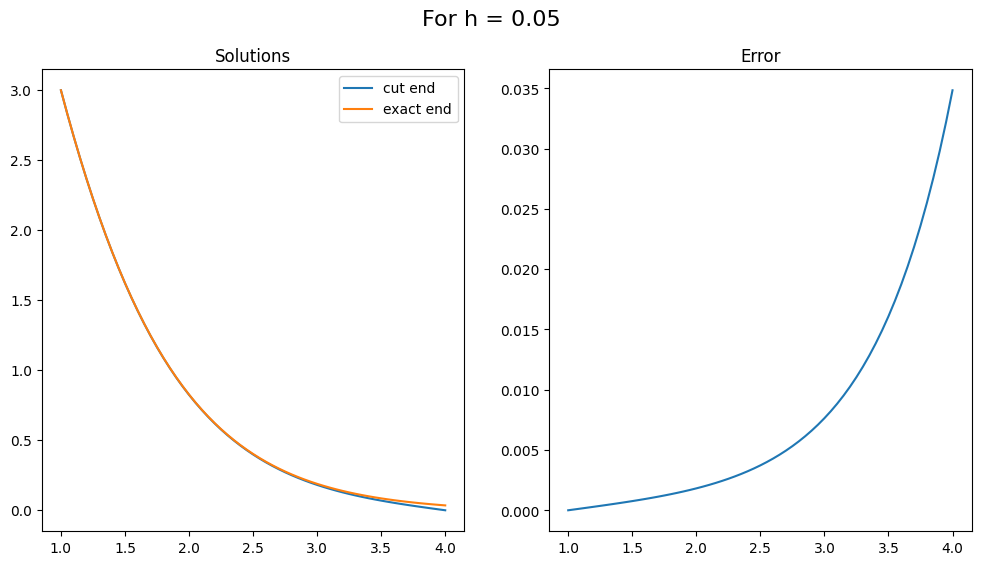

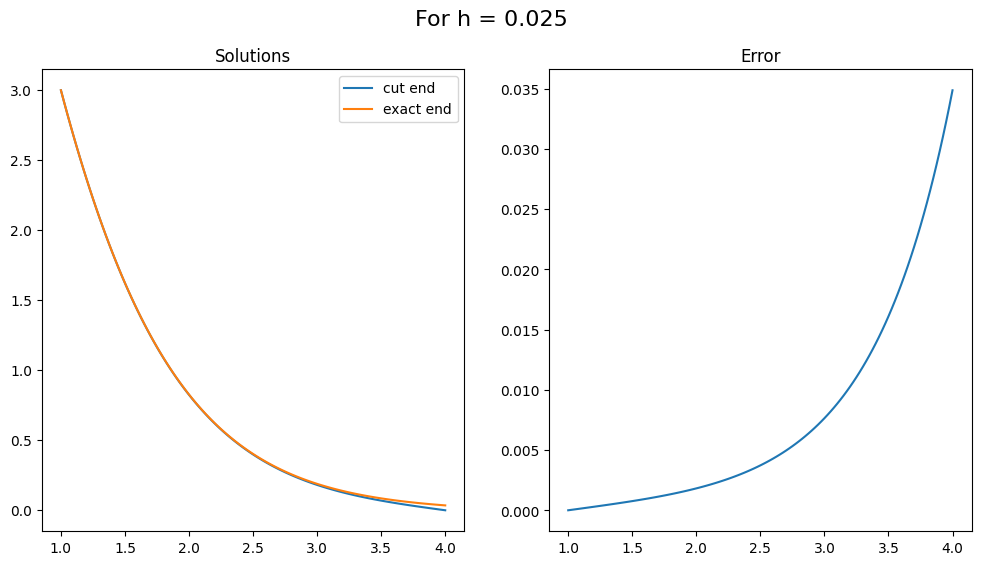

In [13]:
h_values =  [1/10,1/20,1/40]
for h in h_values: 
    fig,ax = plt.subplots(1,2,figsize = (12,6))
    nonacurete1,grid = direct_method2(h,accurate=False)
    accurate1,grid = direct_method2(h)
    fig.suptitle(f"For h = {h}", fontsize=16)
    ax[0].plot(grid,nonacurete1,label = 'cut end')
    ax[0].plot(grid,accurate1,label='exact end')
    ax[0].legend()
    diff = np.mean(np.abs(nonacurete1 - accurate1))
    ax[1].plot(grid,np.abs(nonacurete1 - accurate1))
    ax[1].set_title('Error')
    ax[0].set_title('Solutions')
    print(f'Difference between modified and not modified BC = {diff} for h = {h}')

Ошибка начинается ближе к правой границе, от h несильно что-то менятеся. 

In [14]:
h_values =  [1/10,1/20,1/40]
for h in h_values: 
    nonacurete1,grid = direct_method2(h,accurate=False)
    accurate1,grid = direct_method2(h)
    diff = np.max(np.abs(nonacurete1 - accurate1))
    print(f'Max Difference between modified and not modified BC = {diff} for h = {h}')

Max Difference between modified and not modified BC = 0.03476692080275041 for h = 0.1
Max Difference between modified and not modified BC = 0.03484840657288841 for h = 0.05
Max Difference between modified and not modified BC = 0.034866994144391705 for h = 0.025


# Problem 4

c - complex eigenvalue
$$\omega^{iv} - 2\alpha^2\omega'' + \alpha^4\omega = i\alpha Re\left[(U(z)-c)(\omega'' - \alpha^2\omega) - U''(z)\omega\right]$$
$$\omega = \omega' = 0 \ at \ z = \pm 1.$$

In our case: $U(z) = 1, \alpha = 1, Re = 100$
Equation transforms to: 
$$\omega^{iv} - 2\omega'' + \omega = 100i\left[(1-c)(\omega'' - \omega)\right]$$

$$f_i^{(4)} = \frac{f_{i+2} - 4f_{i+1} + 6f_i - 4f_{i-1}+f_{i-2}}{h^4}$$
$$f_i^{(2)} = \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2}$$
$$f_i' = \frac{4f_{i+1}-3f_i-f_{i+2}}{2h}$$
$$f_i' = \frac{3f_i-4f_{i-1}+f_{i-2}}{2h}$$

\begin{equation}
\begin{gathered}
\frac{1}{h^4}\omega_{i+2} + \omega_{i+1}(-\frac{4}{h^4}-\frac{2}{h^2}-\frac{100i}{h^2})+ \omega_i(\frac{6}{h^4}+\frac{4}{h^2}+ 1 + \frac{200i}{h^2}+ 100i) + \omega_{i-1}(-\frac{4}{h^4}-\frac{2}{h^2}-\frac{100i}{h^2})+\frac{1}{h^4}\omega_{i-2} 
\\= 100i\cdot c\cdot \left(\omega_{i+1}\frac{-1}{h^2}+\omega_i(\frac{2}{h^2}+1) + \omega_{i-1}\frac{-1}{h^2}\right)
\end{gathered}
\end{equation}

$$\omega_0 = 0, \omega_N = 0, \omega_0' = \frac{4\omega_1-\omega_2}{2h}  = 0, \omega_N' = \frac{\omega_{N-2}-4\omega_{N-1}}{2h} = 0 \Rightarrow \omega_1 = \omega_2/4, \omega_{N-1} = \omega_{N-2}/4$$

In [15]:
def Orr_Sommerfeld_eigen(N = 200):
    h = 2/N #2 - length of z interval, N - number of intervals, since we count points from zero. 
    A = np.zeros((N-3,N-3),dtype=complex)
    B = np.zeros((N-3,N-3),dtype=complex)
    a0 = (6/(h**4) + 4/h**2 + 1 + 200j/h**2 +100j)/100j
    a1 = (-4/(h**4) - 2/h**2 - 100j/h**2)/100j
    a2 = (1/(h**4))/100j
    a_1 = (-4/(h**4) - 2/h**2 - 100j/h**2)/100j
    a_2 = (1/(h**4))/100j
    b0 = (2/h**2+1)
    b1 = (-1/h**2)
    b_1 = (-1/h**2)

    for i in range(N-3):
        if i ==0 :
            #A[i][i-2] = a_2
            #A[i][i-1] = a_1
            A[i][i] = a0 + a_1/4
            A[i][i+1] = a1
            A[i][i+2] = a2
            #B[i][i-1] = 100j*b_1
            B[i][i] = b0 + b_1/4
            B[i][i+1] = b1
        elif i==1: 
            #A[i][i-2] = a_2
            A[i][i-1] = a_1 + a_2/4
            A[i][i] = a0
            A[i][i+1] = a1
            A[i][i+2] = a2
            B[i][i-1] = b_1
            B[i][i] = b0
            B[i][i+1] = b1
        elif i==N-5:
            A[i][i-2] = a_2
            A[i][i-1] = a_1
            A[i][i] = a0
            A[i][i+1] = a1 + a2/4
            #A[i][i+2] = a2
            B[i][i-1] = b_1
            B[i][i] = b0
            B[i][i+1] = b1

        elif i == N-4:
            A[i][i-2] = a_2
            A[i][i-1] = a_1
            A[i][i] = a0 + a1/4
            #A[i][i+1] = a1
            B[i][i-1] = b_1
            B[i][i] = b0+b1/4
            #B[i][i+1] = 100j*b1
        else:
            A[i][i-2] = a_2
            A[i][i-1] = a_1
            A[i][i] = a0
            A[i][i+1] = a1
            A[i][i+2] = a2
            B[i][i-1] = b_1
            B[i][i] = b0
            B[i][i+1] = b1
    return eig(A,B)



In [16]:
eigenvalues1,eigenvectors1 = Orr_Sommerfeld_eigen(300)
eigenvalues2,eigenvectors2 = Orr_Sommerfeld_eigen(301)


In [17]:
sort1 = np.sort(np.abs(eigenvalues1))
sort2 = np.sort(np.abs(eigenvalues2))
sort1_mod = np.insert(sort1,0,0)
sort1_mod2 = np.append(sort1,0)

In [18]:
sort1_mod - sort2

array([-1.0043279 , -0.01660916, -0.0522173 , -0.09326985, -0.16746102,
       -0.22225837, -0.30786425, -0.35511307, -0.43646189, -0.47477784,
       -0.55156337, -0.5847307 , -0.65880755, -0.68928735, -0.76181103,
       -0.79083441, -0.86238943, -0.89056175, -0.96143664, -0.9890659 ,
       -1.05940327, -1.08665252, -1.15652136, -1.18347961, -1.25291026,
       -1.27962679, -1.34862855, -1.37513034, -1.44370062, -1.47000162,
       -1.538131  , -1.56423726, -1.63191232, -1.65782494, -1.72502998,
       -1.75074691, -1.81746495, -1.84298207, -1.9091955 , -1.9345073 ,
       -2.0001983 , -2.02529835, -2.09044914, -2.11533039, -2.17992343,
       -2.20457844, -2.26859656, -2.2930176 , -2.35644407, -2.38062328,
       -2.44344188, -2.46737132, -2.52956637, -2.55323812, -2.61479451,
       -2.63820069, -2.69910391, -2.72223671, -2.78247287, -2.80532463,
       -2.86488043, -2.88744362, -2.9463064 , -2.9685737 , -3.02673139,
       -3.04869566, -3.10613684, -3.12779116, -3.18450501, -3.20

In [19]:
sort1_mod2 - sort2 #this approach seemed more realistic

array([ 1.44106282e-10, -7.54302731e-09, -9.95619704e-08, -3.36043389e-07,
       -1.07756576e-06, -2.24299061e-06, -4.56983018e-06, -7.57241599e-06,
       -1.25293213e-05, -1.84584017e-05, -2.73214439e-05, -3.75429639e-05,
       -5.18732659e-05, -6.80371276e-05, -8.96754153e-05, -1.13708462e-04,
       -1.44768840e-04, -1.78870779e-04, -2.21737203e-04, -2.68378956e-04,
       -3.25703657e-04, -3.87626129e-04, -4.62328248e-04, -5.42541616e-04,
       -6.37806088e-04, -7.39588644e-04, -8.58864977e-04, -9.85761960e-04,
       -1.13276281e-03, -1.28858495e-03, -1.46728453e-03, -1.65610631e-03,
       -1.87073849e-03, -2.09689611e-03, -2.35195225e-03, -2.62004128e-03,
       -2.92026780e-03, -3.23514048e-03, -3.58553606e-03, -3.95229827e-03,
       -4.35811077e-03, -4.78211865e-03, -5.24884170e-03, -5.73569790e-03,
       -6.26906710e-03, -6.82461671e-03, -7.43060553e-03, -8.06093161e-03,
       -8.74574693e-03, -9.45716577e-03, -1.02272431e-02, -1.10262990e-02,
       -1.18882973e-02, -

In [20]:
#Our first 5 eigen values are: 
abs_values = np.abs(eigenvalues1)
sorted_indices = np.argsort(abs_values)
smallest_5_elements = eigenvalues1[sorted_indices[:5]]
print(f'First five eigenvalues are {smallest_5_elements}')

First five eigenvalues are [1.-0.09313713j 1.-0.20569993j 1.-0.38943556j 1.-0.60045349j
 1.-0.88274896j]


In [21]:
from scipy.linalg import eig
def Orr_Sommerfeld_eigen2(N = 200):
    h = 2/N #2 - length of z interval, N - number of intervals, since we count points from zero. 
    A = np.zeros((N-3,N-3),dtype=complex)
    B = np.zeros((N-3,N-3),dtype=complex)
    a0 = -2/h**2
    a_1 = 1/h**2
    a1 = 1/h**2
    
    for i in range(N-3):
        if i ==0 :
            A[i][i] = a0 + a_1/4
            A[i][i+1] = a1

        elif i == N-4:
            A[i][i-1] = a_1
            A[i][i] = a0 + a1/4
        else:
            A[i][i-1] = a_1
            A[i][i] = a0
            A[i][i+1] = a1
    I = np.identity(N-3)
    lhs = (np.matmul(A-I,A-I) -100j*(A-I))/(-100j)
    rhs = A - I
    return eig(lhs,rhs)



In [22]:
eigenvalues1,eigenvectors1 = Orr_Sommerfeld_eigen2(500)
eigenvalues2,eigenvectors2 = Orr_Sommerfeld_eigen2(501)
sort1 = np.sort(np.abs(eigenvalues1))
sort2 = np.sort(np.abs(eigenvalues2))
sort1_mod2 = np.append(sort1,1001)
sort1_mod1 = np.insert(sort1,0,1001)

In [23]:
sort1_mod2 - sort2 #this approach seemed more realistic

array([ 1.14580110e-08,  1.14765034e-07,  5.32465910e-07,  1.56569418e-06,
        3.42159824e-06,  6.10759172e-06,  9.45099571e-06,  1.32421205e-05,
        1.73195813e-05,  2.15725934e-05,  2.59161897e-05,  3.02714007e-05,
        3.45565049e-05,  3.86816998e-05,  4.25494530e-05,  4.60528209e-05,
        4.90765154e-05,  5.14962330e-05,  5.31792760e-05,  5.39849044e-05,
        5.37642335e-05,  5.23601659e-05,  4.96078771e-05,  4.53348779e-05,
        3.93604926e-05,  3.14966442e-05,  2.15473177e-05,  9.30901099e-06,
       -5.42943370e-06, -2.28868950e-05, -4.32897237e-05, -6.68719578e-05,
       -9.38749939e-05, -1.24548010e-04, -1.59147435e-04, -1.97937255e-04,
       -2.41188966e-04, -2.89181520e-04, -3.42201270e-04, -4.00541840e-04,
       -4.64504483e-04, -5.34397534e-04, -6.10536852e-04, -6.93245568e-04,
       -7.82854061e-04, -8.79700023e-04, -9.84128337e-04, -1.09649118e-03,
       -1.21714785e-03, -1.34646486e-03, -1.48481586e-03, -1.63258159e-03,
       -1.79014991e-03, -

In [24]:
sort1_mod1 - sort2

array([ 9.99999394e+02, -5.34151076e-03, -2.08945059e-02, -5.27622677e-02,
       -1.02350512e-01, -1.65348603e-01, -2.34249320e-01, -3.02887020e-01,
       -3.68376487e-01, -4.30228093e-01, -4.88960246e-01, -5.45295845e-01,
       -5.99866342e-01, -6.53151583e-01, -7.05497401e-01, -7.57148498e-01,
       -8.08277582e-01, -8.59007156e-01, -9.09424849e-01, -9.59593951e-01,
       -1.00956062e+00, -1.05935884e+00, -1.10901380e+00, -1.15854433e+00,
       -1.20796453e+00, -1.25728502e+00, -1.30651379e+00, -1.35565680e+00,
       -1.40471852e+00, -1.45370220e+00, -1.50261017e+00, -1.55144404e+00,
       -1.60020485e+00, -1.64889317e+00, -1.69750921e+00, -1.74605289e+00,
       -1.79452389e+00, -1.84292169e+00, -1.89124561e+00, -1.93949485e+00,
       -1.98766851e+00, -2.03576559e+00, -2.08378501e+00, -2.13172567e+00,
       -2.17958638e+00, -2.22736594e+00, -2.27506309e+00, -2.32267659e+00,
       -2.37020512e+00, -2.41764740e+00, -2.46500209e+00, -2.51226788e+00,
       -2.55944343e+00, -

In [25]:
#Our first 5 eigen values are: 
#Maybe I should choose eigenvalues with the smallest difference? 
abs_values = np.abs(eigenvalues1)
sorted_indices = np.argsort(abs_values)
smallest_5_elements = eigenvalues1[sorted_indices[:6]]
print('First six eigenvalues are')
for e in smallest_5_elements:
    print(e)

First six eigenvalues are
(0.9999999995782745-0.03480605951184324j)
(0.9999999994937124-0.10922323546710822j)
(0.9999999991810788-0.23324863975490048j)
(1.0000000003903817-0.4068773898267765j)
(1.0000000006538008-0.6301026810072502j)
(1.0000000002416114-0.9029157599549554j)


In [26]:
#Our first 5 eigen values are: 
#Maybe I should choose eigenvalues with the smallest difference? 
abs_values = np.abs(eigenvalues2)
sorted_indices = np.argsort(abs_values)
smallest_5_elements = eigenvalues2[sorted_indices[:6]]
print('First six eigenvalues are')
for e in smallest_5_elements:
    print(e)

First six eigenvalues are
(0.999999998211776-0.03480576937579144j)
(0.9999999989993209-0.10922218300133402j)
(1.000000002183294-0.23324628277085213j)
(1.000000000755001-0.4068732345088031j)
(0.9999999997077024-0.6300962641787845j)
(0.9999999998858108-0.902906646684953j)


# Problem 5

$$y'''' + c^2y'' + y^+ = 1,$$
$y^+ = \max\{y,0\}$.  

\begin{equation}
\begin{cases}
y'''' + c^2y'' + \theta(y)y = 0,
\\y_0 = 1,
\\y_{-1} = 1,
\\y_1 =\frac{3+y_2}{4}
\\y_{-2} = \frac{3+y_{-3}}{4}
\end{cases}
\end{equation}
$$f_i^{(4)} = \frac{f_{i+2} - 4f_{i+1} + 6f_i - 4f_{i-1}+f_{i-2}}{h^4}$$
$$f_i^{(2)} = \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2}$$

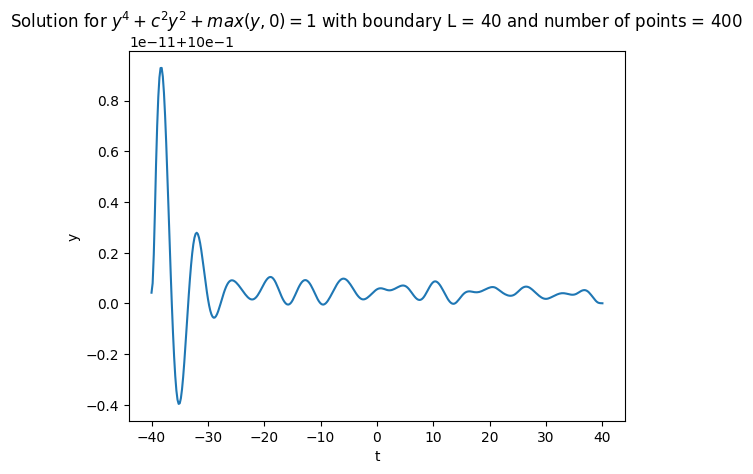

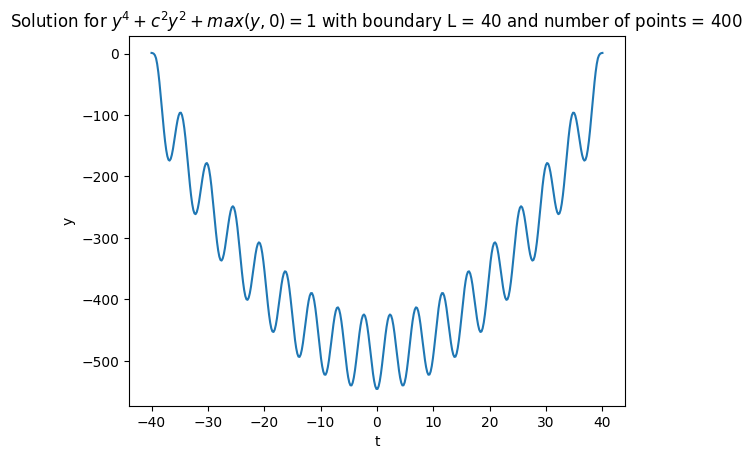

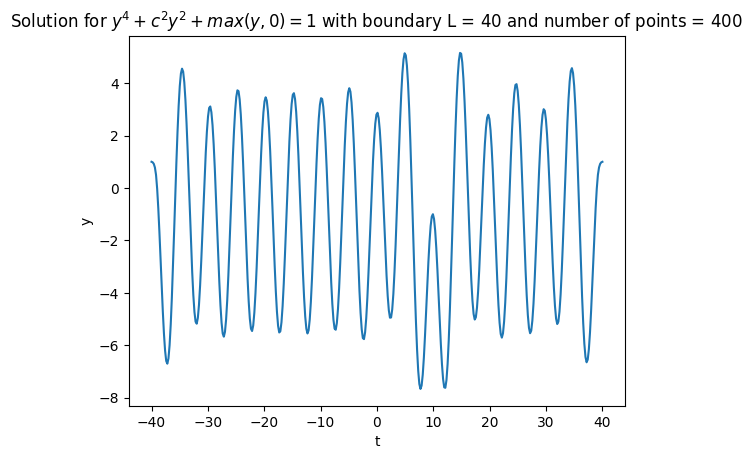

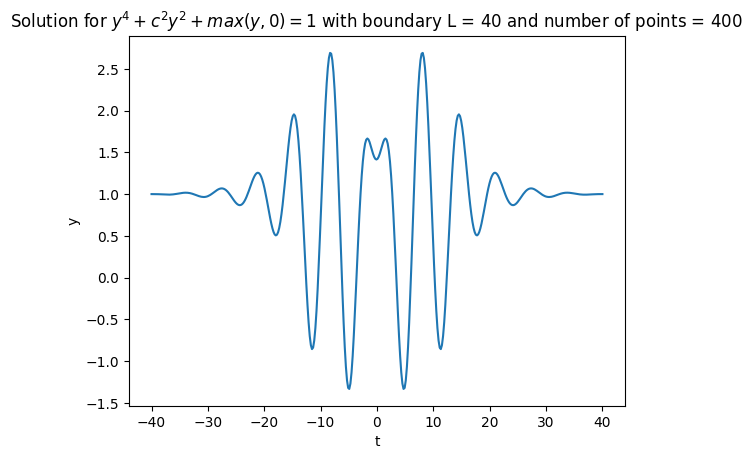

In [27]:
def Heaviside(y):
    return (y>0)+0
def trial1(y_guess,N = 200,L = 10,c=1.83297):
    #h = 2*L/N #2 - length of z interval, N - number of intervals, since we count points from zero.
    x = np.linspace(-L,L,num = N) 
    h = abs(x[1] - x[0])
    #y_guess = np.array([1 for i in range(N-3)])
    theta = Heaviside(y_guess)
    A = np.zeros((N,N))
    b = np.ones((N,1))
    a0 = 6/(h**4) - (2*c)/h**2 
    a1 = -4/(h**4) +c/h**2
    a2 = 1/(h**4)
    a_1 = -4/(h**4) +c/h**2
    a_2 = 1/(h**4)

    A[0][0] = 1
    A[-1][-1] = 1

    A[1][0] = -3
    A[1][1] = 4
    A[1][2] = -1

    A[-2][-3] = 1
    A[-2][-2] = -4
    A[-2][-1] = 3
    
    A[2][0] = 2
    A[2][1] = -5
    A[2][2] = 4
    A[2][3] = -1

    A[-3][-1] = 2
    A[-3][-2] = -5
    A[-3][-3] = 4
    A[-3][-4] = -1


    A[3][0] = -5
    A[3][1] = 18
    A[3][2] = -24
    A[3][3] = 14
    A[3][4] = -3

    A[-4][-1] = 5
    A[-4][-2] = -18
    A[-4][-3] = 24
    A[-4][-4] = -14
    A[-4][-5] = 3

    A[4][0] = 3
    A[4][1] = -14
    A[4][2] = 26
    A[4][3] = -24
    A[4][4] = 11
    A[4][5] = -2

    A[-5][-1] = 3
    A[-5][-2] = -14
    A[-5][-3] = 26
    A[-5][-4] = -24
    A[-5][-5] = 11
    A[-5][-6] = -2


    b[0] = 1
    b[-1] = 1

    b[1] = 0
    b[-2] = 0

    b[2] = 0
    b[-3] = 0

    b[3] = 0
    b[-4] = 0
    b[4] = 0
    b[-5] = 0
    
    

    for i in range(5,N-5):
        A[i][i-2] = a_2
        A[i][i-1] = a_1
        A[i][i] = a0 + theta[i]
        A[i][i+1] = a1
        A[i][i+2] = a2
    return np.linalg.solve(A,b).flatten()

def iterate(tolerance=1e-8, N = 100,L = 50,guess = np.array([(1)**i for i in range(100)])):
    #guess =np.array([(1)**i for i in range(N)]) 
    while True: 
        y1 = trial1(guess,N = N,L =L )
        if np.max(abs(y1-guess))<tolerance:
            break
        else:
            omega = 0.5
            #guess = (1 - omega) * guess + omega * y1 
            guess = y1
    x = np.linspace(-L,L,num = N)
    plt.plot(x,y1)
    plt.title(fr'Solution for $y^{(4)}+c^2y^{(2)} + max(y,0) = 1$ with boundary L = {L} and number of points = {N} ')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.show();
    return y1
guess1 = np.array([(1) for i in range(400)])
guess2 = np.array([(-1) for i in range(400)])
guess3 = np.array([(-1)**i for i in range(400)])
guess4 = np.array([(-1)**i for i in range(400)])
guess4[:185] = 1
guess4[-185:] = 1

y1 = iterate(tolerance=1e-9,N = 400,L = 40, guess = guess1)
y2 = iterate(tolerance=1e-9,N = 400,L = 40, guess = guess2)
y3 = iterate(tolerance=1e-9,N = 400,L = 40, guess = guess3)
y4 = iterate(tolerance=1e-9,N = 400,L = 40, guess = guess4)